In [1]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]

In [2]:
#Clean data and create intended features
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2020-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2020-02-07 00:00:00-05:00,3335.540039,3341.419922,3322.120117,3327.709961,3733920000,3352.090088,1,0.997497,0.333333,1.012781,0.2,1.012828,0.20
2020-02-10 00:00:00-05:00,3318.280029,3352.260010,3317.770020,3352.090088,3462730000,3357.750000,1,1.003061,0.333333,1.016845,0.4,1.018794,0.28
2020-02-11 00:00:00-05:00,3365.870117,3375.629883,3352.719971,3357.750000,3762940000,3379.449951,1,1.003557,0.333333,1.016050,0.4,1.019133,0.28
2020-02-12 00:00:00-05:00,3370.500000,3381.469971,3369.719971,3379.449951,3930910000,3373.939941,-1,1.004863,1.000000,1.019345,0.6,1.023951,0.36
2020-02-13 00:00:00-05:00,3365.899902,3385.090088,3360.520020,3373.939941,3500890000,3380.159912,1,1.001056,0.333333,1.014919,0.4,1.020786,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12 00:00:00-04:00,5171.509766,5175.029785,5107.939941,5123.410156,3963220000,5061.819824,-1,0.992709,-0.333333,0.987017,-0.2,0.987469,-0.12
2024-04-15 00:00:00-04:00,5149.669922,5168.430176,5052.470215,5061.819824,3950210000,5051.410156,-1,0.987076,-0.333333,0.978582,-0.2,0.976064,-0.12
2024-04-16 00:00:00-04:00,5064.589844,5079.839844,5039.830078,5051.410156,4006200000,5022.209961,-1,0.994591,-1.000000,0.979493,-0.2,0.974556,-0.12


In [3]:
from numpy.random import default_rng
import math

#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)

#padding predictors to match input size
final_predictors = []
for index,arr in enumerate(predictors):
    tmpList = predictors[index].tolist();
    while not math.log(len(tmpList), 2).is_integer():
        tmpList.append(0);
    final_predictors.append(tmpList);
predictors = np.array(final_predictors)
#padding predictors to match input size

labels = (DataFrame.to_numpy(sp500))[:,6]
train_predictors = predictors[1:948,:]
test_predictors = predictors[949:np.size(predictors, axis=0),:]
rng = default_rng()
numbers = rng.choice(949, size=100, replace=False)
encoder_training_predictors = predictors[numbers]
encoder_training_labels = labels[numbers]
train_labels = labels[0:948]
test_labels = labels[949:np.size(predictors, axis=0)]
num_features = np.size(predictors, axis=1)

In [4]:
import json
import time
import warnings
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

# 5 pieces of data -> 3 pieces of data
#Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

In [5]:
encoding_depth = 2
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=encoding_depth)

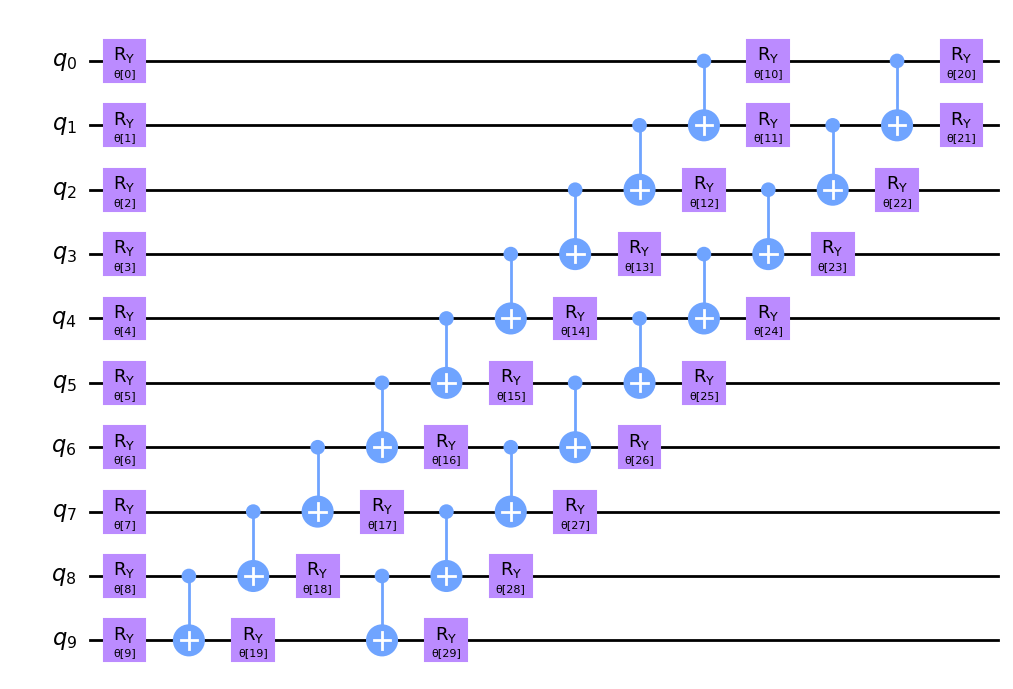

In [6]:
num_qubits = 10
circ = ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")

In [7]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import Initialize
from qiskit_machine_learning.circuit.library import RawFeatureVector
'''
references:
1. https://stackoverflow.com/questions/68257662/qiskit-vqc-with-amplitude-encoding-for-state-preparation
2. https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.circuit.library.RawFeatureVector.html#
3. 
'''
#print(num_features);
#feature_map = Initialize(num_features)
feature_map = RawFeatureVector(16)
#feature_map.decompose().draw("mpl", style="clifford")

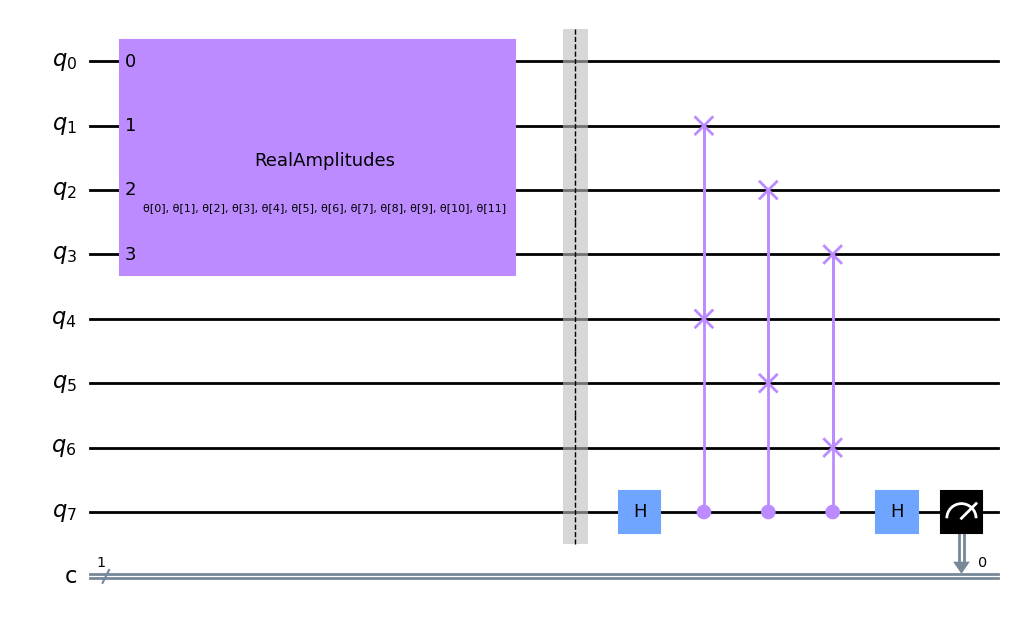

In [8]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 1
num_trash = 3
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

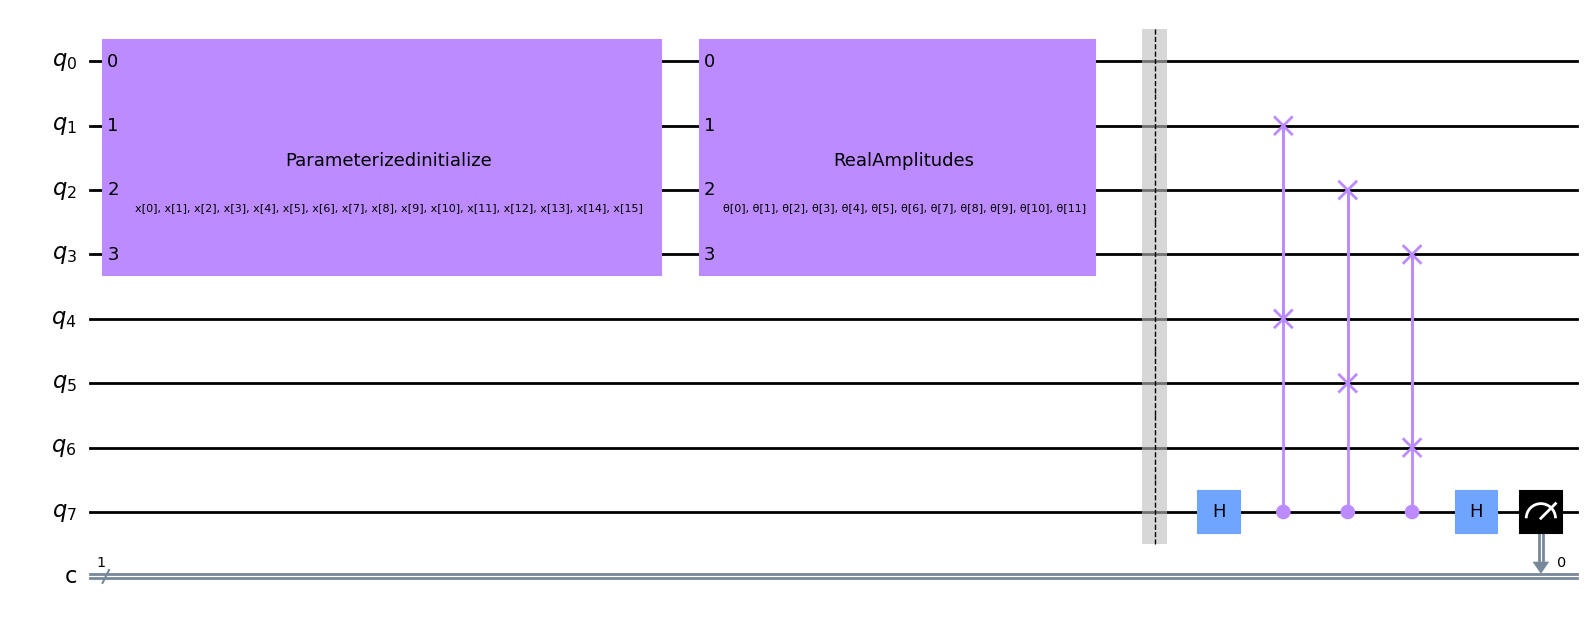

In [9]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc.compose(feature_map, inplace=True)
qc.compose(ae, inplace=True)
qc.draw(output="mpl", style="clifford")

In [10]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [11]:
def cost_func_domain(params_values):
    probabilities = qnn.forward(encoder_training_predictors, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

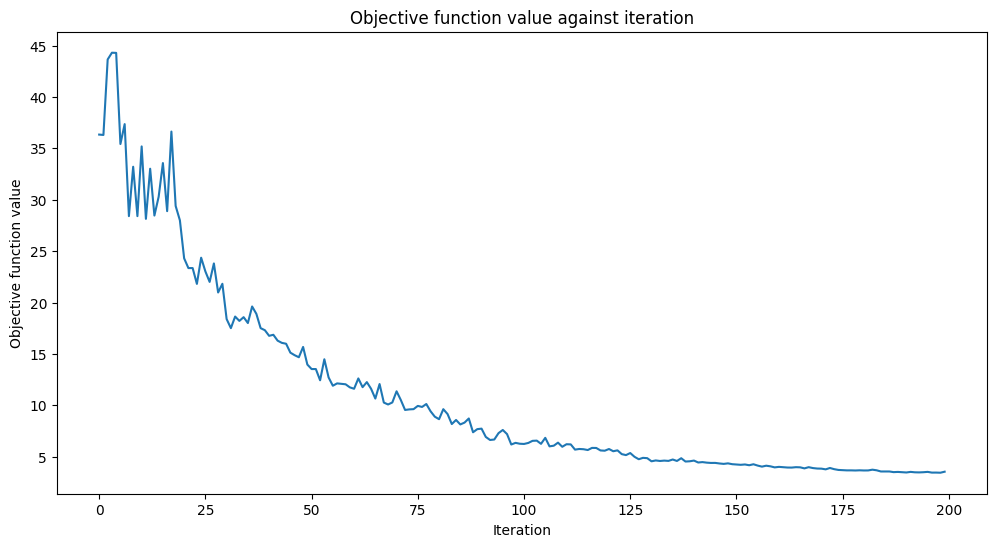

[ 2.63897016  1.25771487  0.01165546  0.00934777 -0.01014019 -0.01292645
  0.8681907   1.58906634  1.10426896  2.10709697  1.70177485  1.58345664]


In [12]:
opt = COBYLA(maxiter=200)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

opt_result = opt.minimize(cost_func_domain, initial_point)

#trained parameters
print(opt_result.x)

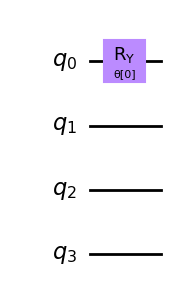

In [13]:
#Function to create the gates with parameters that we will modify through ML techniques
from qiskit.circuit import ParameterVector
num_params = num_latent

def parametrized_gates(params):
    target = QuantumCircuit(4)
        
    #for i in range(num_params):
    #    target.ry(params[i], i)
        
    #for i in range(num_params-1):
    #    target.cx(i, i+1)
        
    #target.cx(num_params-1,0)
    target.ry(params[0], 0)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

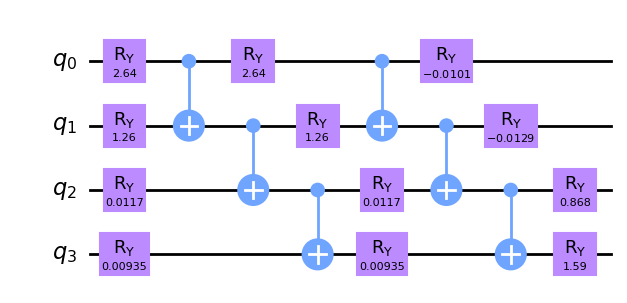

In [14]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = (encoding_depth+1)*num_features
def trained_encoder(params):
    target = QuantumCircuit(4)
    
    for i in range(4):
        target.ry(params[i], i)
        
    for i in range(encoding_depth):
        for j in range(4):
            if (j!=3):
                target.cx(j, j+1)
            target.ry(params[j + 4*i], j)
    
    return target

#Draws the ciruit for parametrized gate
circuit = trained_encoder(opt_result.x)
circuit.draw("mpl", style="clifford")

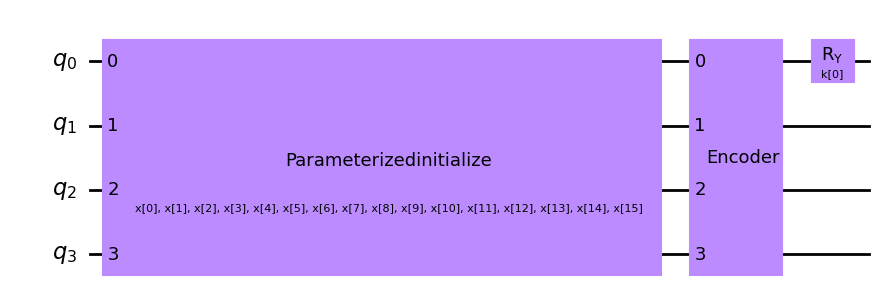

In [15]:
#Sets up full circuit with inputs and network
#network.clear()
#ml_circuit.clear()
#circuit_depth = 7
#network = parametrized_gates(ParameterVector("θ1", length=num_params))
#for i in range(circuit_depth-1):
#    network.compose(parametrized_gates(ParameterVector(f"θ{i+2}", length=num_params)), inplace=True)
network = parametrized_gates(ParameterVector("k", length=num_params))
ml_circuit = QuantumCircuit(4)
ml_circuit.compose(feature_map, inplace=True)
e = trained_encoder(opt_result.x)
e = e.to_instruction(label="Encoder")
ml_circuit.append(e, range(4))
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [16]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [17]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("I" * 3 + "Z", 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [18]:
#Function used in classifier to plot objective function at each iteration
max_iters = 200
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [19]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=max_iters),
    callback=callback_graph
)

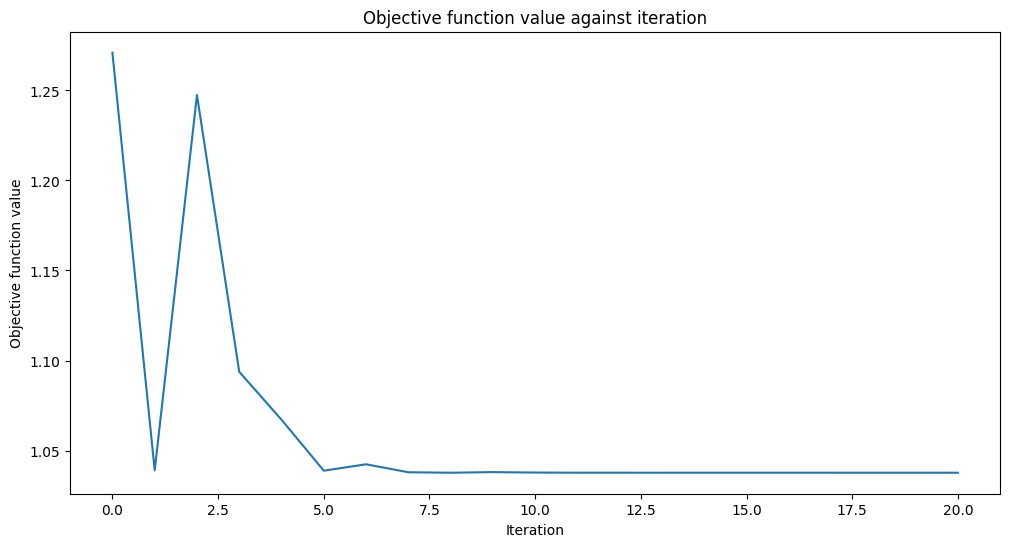

Accuracy from the test data : 49.72%


In [20]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(encoder_training_predictors, encoder_training_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(predictors, labels), 2)}%")

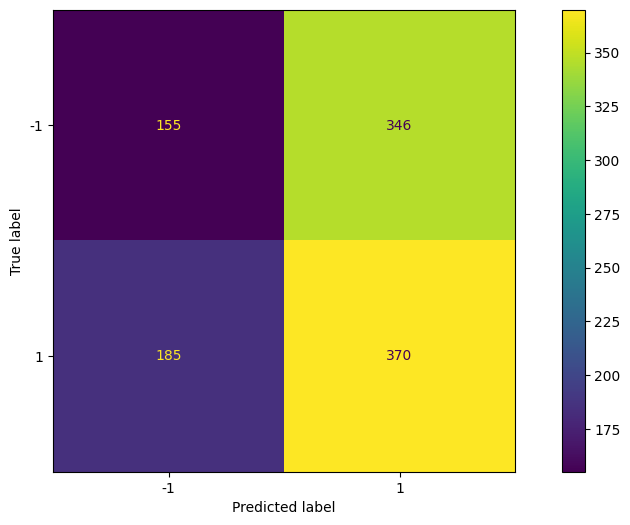

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, classifier.predict(predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()

In [22]:
print(num_params)

48
